In [10]:
import sys
import os
print('Python version:', sys.version)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor


try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

print('xgboost available:', XGBOOST_AVAILABLE)
print('imblearn available:', IMBLEARN_AVAILABLE)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
sns.set(style='whitegrid')


Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
xgboost available: False
imblearn available: True


In [3]:
data_path = 'Fraud.csv'  # <- change if your file has a different name

if not os.path.exists(data_path):
    print(f'File not found: {data_path}')
    print('Place the downloaded CSV in the same folder as this notebook or update data_path.')
else:
    # For very large files, consider reading a sample first:
    # df = pd.read_csv(data_path, nrows=200000)
    df = pd.read_csv(data_path)
    print('Loaded dataset with shape:', df.shape)
    display(df.head())

Loaded dataset with shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
def basic_overview(df):
    print('Rows, Columns:', df.shape)
    print('\nData types:')
    print(df.dtypes)
    print('\nMissing values per column:')
    print(df.isna().sum().sort_values(ascending=False).head(20))
    print('\nBasic description:')
    display(df.describe(include='all').T.head(30))

try:
    basic_overview(df)
except NameError:
    print('Dataset not loaded. Run the previous cell to load the CSV.')

Rows, Columns: (6362620, 11)

Data types:
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

Missing values per column:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Basic description:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
step,6362620.0,NaN,NaN,NaN,243.397246,142.331971,1.0,156.0,239.0,335.0,743.0
type,6362620,5,CASH_OUT,2237500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,6362620.0,NaN,NaN,NaN,179861.903549,603858.231463,0.0,13389.57,74871.94,208721.4775,92445516.64
nameOrig,6362620,6353307,C1677795071,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceOrg,6362620.0,NaN,NaN,NaN,833883.104074,2888242.673038,0.0,0.0,14208.0,107315.175,59585040.37
newbalanceOrig,6362620.0,NaN,NaN,NaN,855113.668579,2924048.502954,0.0,0.0,0.0,144258.41,49585040.37
nameDest,6362620,2722362,C1286084959,113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldbalanceDest,6362620.0,NaN,NaN,NaN,1100701.66652,3399180.112994,0.0,0.0,132705.665,943036.7075,356015889.35
newbalanceDest,6362620.0,NaN,NaN,NaN,1224996.398202,3674128.94212,0.0,0.0,214661.44,1111909.25,356179278.92
isFraud,6362620.0,NaN,NaN,NaN,0.001291,0.035905,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Handling the missing value 


If column has >50% missing consider dropping 
for numerical value: use median imputation robustness agianst outlier
for categorical value use :mode
for time series or ordered  data consider forward /backward 

In [6]:
try:
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    print('Numeric cols:', len(num_cols))
    print('Categorical cols:', len(cat_cols))
    
    num_imputer = SimpleImputer(strategy='median')
    cat_imputer = SimpleImputer(strategy='most_frequent')

    df[num_cols] = num_imputer.fit_transform(df[num_cols])
    df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
    print('Imputation completed (example).')
except NameError:
    print('df not loaded.')

Numeric cols: 8
Categorical cols: 3
Imputation completed (example).


5) Outlier 
 Use IQR or z score :  outlier might be Fraud signle: do not blindly drop them  
 consider capping extreme values  for some  feature if  they break the    model stability 

IQR bounds for amount: -279608.29125 501719.33875
Num outliers above upper bound: 338078


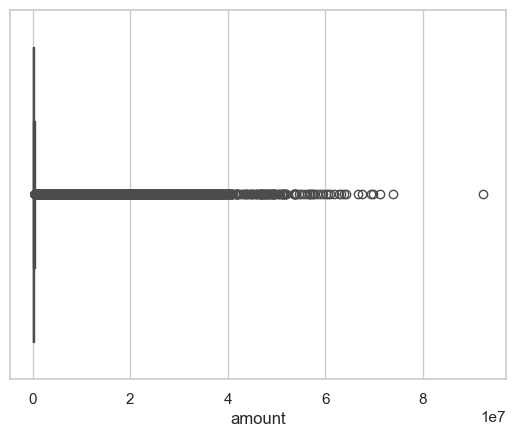

In [7]:
def iqr_outliers(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

try:
    if 'amount' in df.columns:
        lower, upper = iqr_outliers(df['amount'].dropna())
        print('IQR bounds for amount:', lower, upper)
        print('Num outliers above upper bound:', (df['amount'] > upper).sum())
        sns.boxplot(x=df['amount'].replace([np.inf, -np.inf], np.nan).dropna())
        plt.show()
    else:
        print('Column "amount" not found; change to your numeric column for outlier analysis.')
except NameError:
    print('df not loaded.')

6)  Multi- collinearity
compute correlation matrix for numeric feature  and VIF  
if VIf > 10 or 5 , consider dropping  combining feature 

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
try:
    numeric_df = df.select_dtypes(include=['int64','float64']).dropna(axis=1)
    X_vif = numeric_df.loc[:, numeric_df.columns]
    X_vif = X_vif.fillna(0)
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_vif.columns
    vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
    display(vif_data.sort_values('VIF', ascending=False).head(20))
except Exception as e:
    print('VIF computation skipped or failed:', e)

,feature,VIF
3,newbalanceOrig,546.346008
2,oldbalanceOrg,544.053103
5,newbalanceDest,84.584619
4,oldbalanceDest,72.895522
1,amount,4.078952
0,step,1.191094
6,isFraud,1.188386
7,isFlaggedFraud,1.002546


7) Exploratory Data  Analysis (EDA)
check  class imblance 
Plot distribution 
Time bases trend  if time present 

Using target column: isFlaggedFraud


isFlaggedFraud
0.0    0.999997
1.0    0.000003
Name: proportion, dtype: float64

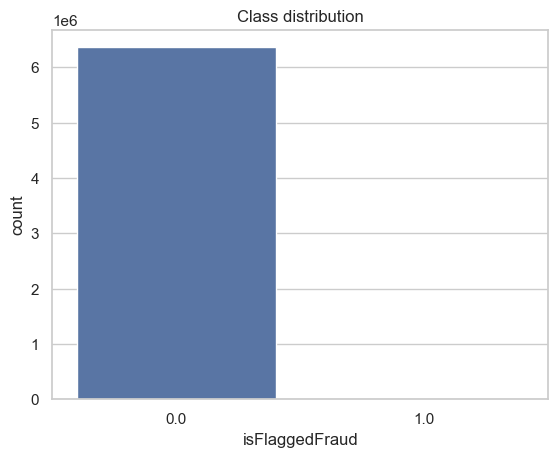

In [12]:
try:
    target_col = 'is_fraud' if 'is_fraud' in df.columns else df.columns[-1]
    print('Using target column:', target_col)
    display(df[target_col].value_counts(normalize=True))
    sns.countplot(x=df[target_col])
    plt.title('Class distribution')
    plt.show()
except NameError:
    print('df not loaded.')

8) Feature Engineering ideas 
Time based feature : hours  day -and- week  since last transaction 
Aggeration per user : average transaction amount count , last 24 hoours 
Device IP feature number of distict devices , geolocation distance   

In [13]:
try:
    if 'transaction_time' in df.columns or 'timestamp' in df.columns:
        ts_col = 'transaction_time' if 'transaction_time' in df.columns else 'timestamp'
        df[ts_col] = pd.to_datetime(df[ts_col], errors='coerce')
        df['hour'] = df[ts_col].dt.hour
        df['dayofweek'] = df[ts_col].dt.dayofweek
        display(df[[ts_col, 'hour', 'dayofweek']].head())
    else:
        print('No timestamp-like column found; skip time features or rename your timestamp column.')
except NameError:
    print('df not loaded.')

No timestamp-like column found; skip time features or rename your timestamp column.


9) Feature  selection And Modeling pipeline 
We'll build a robust pipeline using scikit-learn. for handling imbalance you can either use class_weight in models or apply SMOTE on the training set.

In [14]:
try:
    drop_cols = ['id'] if 'id' in df.columns else []
    target_col = 'is_fraud' if 'is_fraud' in df.columns else df.columns[-1]
    features = [c for c in df.columns if c not in drop_cols + [target_col]]
    X = df[features]
    y = df[target_col].astype(int)
    print('Feature count:', X.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

    numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
    numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])

    preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)], remainder='drop')

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))])

    clf.fit(X_train[numeric_features], y_train)
    y_pred = clf.predict(X_test[numeric_features])
    print('Classification report:')
    print(classification_report(y_test, y_pred))
    try:
        print('ROC-AUC (prob):', roc_auc_score(y_test, clf.predict_proba(X_test[numeric_features])[:,1]))
    except Exception:
        pass
except Exception as e:
    print('Modeling step skipped or failed (likely due to missing columns or large dataset):', e)

Feature count: 10
Train shape: (5090096, 10) Test shape: (1272524, 10)
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1272521
           1       1.00      0.67      0.80         3

    accuracy                           1.00   1272524
   macro avg       1.00      0.83      0.90   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC (prob): 1.0


Hyperparameter tuning 
1 Use  RandomizedSearchCV or GridSearch with StratifiedkFold.
For big data,tune on a sample or use randomized search.
Track metrics like recall (catch more fraud)and precision depending on business cost.

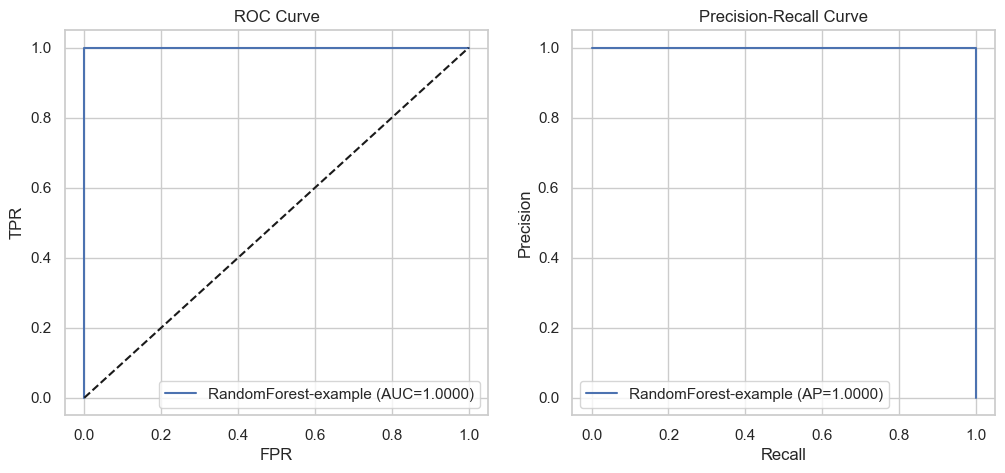

In [15]:
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_roc_pr(clf, X_test, y_test, label='Model'):
    y_score = clf.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, label=f'{label} (AUC={auc(fpr,tpr):.4f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recall, precision, label=f'{label} (AP={auc(recall,precision):.4f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
    plt.show()

try:
    plot_roc_pr(clf, X_test[numeric_features], y_test, label='RandomForest-example')
except Exception as e:
    print('Plotting skipped or failed:', e)

10) Feature importance and interpretation 
 For tree- based models , extract  feature_importance and show top predictors .
 For linear models ,use  cofficients and look at sign + magnitude.
 

,feature,importance
6,isFraud,0.394384
1,amount,0.210769
2,oldbalanceOrg,0.142831
3,newbalanceOrig,0.121872
0,step,0.058871
5,newbalanceDest,0.047521
4,oldbalanceDest,0.023754


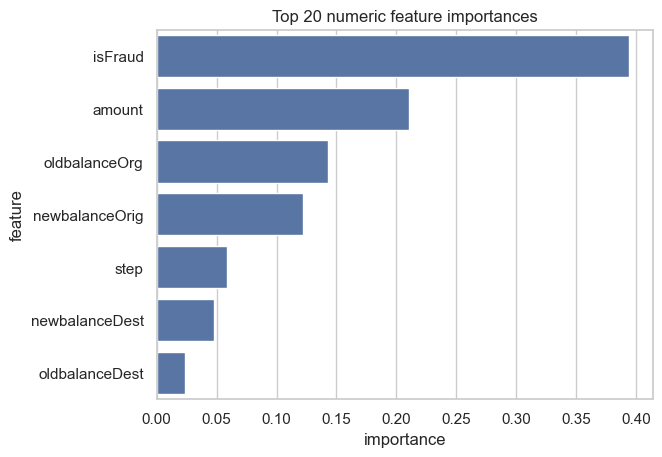

In [16]:
try:
    rf = clf.named_steps['classifier']
    importances = rf.feature_importances_
    feats = numeric_features
    imp_df = pd.DataFrame({'feature': feats, 'importance': importances}).sort_values('importance', ascending=False)
    display(imp_df.head(30))
    sns.barplot(data=imp_df.head(20), x='importance', y='feature')
    plt.title('Top 20 numeric feature importances')
    plt.show()
except Exception as e:
    print('Feature importance extraction failed:', e)

11)  Recommendations and Monitoring 
Prevention 
1 Real- time scoring alerting system 
2 Multi-factor authentication 
3 Device Fingerprinting and Geolocation checks  
4 Rate limiting and velocity rules 
5 Hybrid system: ML models + rules based checks  